**Description**

`contract.csv` — информация о договоре;
`personal.csv` — персональные данные клиента;
`internet.csv` — информация об интернет-услугах;
`phone.csv` — информация об услугах телефонии.

In [1]:
!pip install imblearn
!pip install phik
!pip install lightgbm
!pip install xgboost

**Import libraries**

In [2]:
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import warnings
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer,plot_confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score,precision_score,recall_score

warnings.filterwarnings('ignore')
random_seed=12345
%matplotlib inline
plt.rcParams['figure.figsize']=16,8

**Create df's**

In [3]:
contract = pd.read_csv('datasets/final_provider/contract.csv')
personal = pd.read_csv('datasets/final_provider/personal.csv')
internet = pd.read_csv('datasets/final_provider/internet.csv')
phone = pd.read_csv('datasets/final_provider/phone.csv')

dfs = [personal,internet,phone,contract]
for df in dfs:
    df.columns = df.columns.str.lower().str.replace(' ', '')
df= reduce(lambda left,right: pd.merge(left,right,on='customerid',how='outer'), dfs)
for column in df.columns:
    if df[column].dtype == 'object':
        df[column]=df[column].str.strip().str.lower()

# 1. EDA #

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   internetservice   5517 non-null   object 
 6   onlinesecurity    5517 non-null   object 
 7   onlinebackup      5517 non-null   object 
 8   deviceprotection  5517 non-null   object 
 9   techsupport       5517 non-null   object 
 10  streamingtv       5517 non-null   object 
 11  streamingmovies   5517 non-null   object 
 12  multiplelines     6361 non-null   object 
 13  begindate         7043 non-null   object 
 14  enddate           7043 non-null   object 
 15  type              7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


In [5]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-vhveg,female,0,yes,no,dsl,no,yes,no,no,no,no,NaN,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85
1,5575-gnvde,male,0,no,no,dsl,yes,no,yes,no,no,no,no,2017-04-01,no,one year,no,mailed check,56.95,1889.50
2,3668-qpybk,male,0,no,no,dsl,yes,yes,no,no,no,no,no,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15
3,7795-cfocw,male,0,no,no,dsl,yes,no,yes,yes,no,no,NaN,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75
4,9237-hqitu,female,0,no,no,fiber optic,no,no,no,no,no,no,no,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65


In [6]:
df.tail()

,customerid,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
7038,6840-resvb,male,0,yes,yes,dsl,yes,no,yes,yes,yes,yes,yes,2018-02-01,no,one year,yes,mailed check,84.80,1990.50
7039,2234-xaduh,female,0,yes,yes,fiber optic,no,yes,yes,no,yes,yes,yes,2014-02-01,no,one year,yes,credit card (automatic),103.20,7362.90
7040,4801-jzazl,female,0,yes,yes,dsl,yes,no,no,no,no,no,NaN,2019-03-01,no,month-to-month,yes,electronic check,29.60,346.45
7041,8361-ltmkd,male,1,yes,no,fiber optic,no,no,no,no,no,no,yes,2019-07-01,2019-11-01 00:00:00,month-to-month,yes,mailed check,74.40,306.60
7042,3186-ajiek,male,0,no,no,fiber optic,yes,no,yes,yes,yes,yes,no,2014-08-01,no,two year,yes,bank transfer (automatic),105.65,6844.50


In [7]:
print(df.isna().mean() * 100)

customerid           0.000000
gender               0.000000
seniorcitizen        0.000000
partner              0.000000
dependents           0.000000
internetservice     21.666903
onlinesecurity      21.666903
onlinebackup        21.666903
deviceprotection    21.666903
techsupport         21.666903
streamingtv         21.666903
streamingmovies     21.666903
multiplelines        9.683374
begindate            0.000000
enddate              0.000000
type                 0.000000
paperlessbilling     0.000000
paymentmethod        0.000000
monthlycharges       0.000000
totalcharges         0.156183
dtype: float64


In [8]:
df.describe()

,seniorcitizen,monthlycharges,totalcharges
count,7043.000000,7043.000000,7032.000000
mean,0.162147,64.761692,2283.300441
std,0.368612,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,0.000000,35.500000,401.450000
50%,0.000000,70.350000,1397.475000
75%,0.000000,89.850000,3794.737500
max,1.000000,118.750000,8684.800000


Выведем основную информацию

In [9]:
df.loc[df['totalcharges'].isna()]

,customerid,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
488,4472-lvygi,female,0,yes,yes,dsl,yes,no,yes,yes,yes,no,NaN,2020-02-01,no,two year,yes,bank transfer (automatic),52.55,NaN
753,3115-czmzd,male,0,no,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,2020-02-01,no,two year,no,mailed check,20.25,NaN
936,5709-lvoeq,female,0,yes,yes,dsl,yes,yes,yes,no,yes,yes,no,2020-02-01,no,two year,no,mailed check,80.85,NaN
1082,4367-nuyao,male,0,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,2020-02-01,no,two year,no,mailed check,25.75,NaN
1340,1371-dwpaz,female,0,yes,yes,dsl,yes,yes,yes,yes,yes,no,NaN,2020-02-01,no,two year,no,credit card (automatic),56.05,NaN
3331,7644-omvmy,male,0,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,2020-02-01,no,two year,no,mailed check,19.85,NaN
3826,3213-vvolg,male,0,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,2020-02-01,no,two year,no,mailed check,25.35,NaN
4380,2520-sgtta,female,0,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,2020-02-01,no,two year,no,mailed check,20.00,NaN
5218,2923-arzlg,male,0,yes,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,2020-02-01,no,one year,yes,mailed check,19.70,NaN
6670,4075-wkniu,female,0,yes,yes,dsl,no,yes,yes,yes,yes,no,yes,2020-02-01,no,two year,no,mailed check,73.35,NaN


In [10]:
df['begindate'].sort_values(ascending=False)

6670    2020-02-01
1082    2020-02-01
488     2020-02-01
3826    2020-02-01
3331    2020-02-01
           ...    
3040    2013-11-01
975     2013-11-01
3439    2013-10-01
4610    2013-10-01
4513    2013-10-01
Name: begindate, Length: 7043, dtype: object

В totalcharges имеется 0.15% пропусков, что несущественно. Так же все пропуски приходятся на последнюю актуальную дату, что указывает на новое подключение. Поэтому значения в totalcharges можно заменить на значения в monthlycharges.
Количество пользователей интернет-услуг меньше общего количества пользователей. Так же нужно убедиться в отсутствии пользователей без каких-либо услуг.
Как и с интернет-услугами количество пользователей с подключенной телефонией меньше обещего количества пользователей.

In [11]:
df['totalcharges'] = df['totalcharges'].fillna(df['monthlycharges'])

In [12]:
df['totalcharges'].isna().sum()

0

In [13]:
df.loc[(df['internetservice'].isna()) & (df['multiplelines'].isna())].sum().sum()

0.0

Количество пользователей без подключенных услуг =0

In [14]:
df.isna().sum()

customerid             0
gender                 0
seniorcitizen          0
partner                0
dependents             0
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
multiplelines        682
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
dtype: int64

Пользователи без поделюченных услуг интернета или телефонии отсутствуют, поэтому пропущенные значения заменим в столбцах интернет услуг заменим на "no".
Т.к. столбец MultipleLines представляет собой булевый тип, описывающий наличие одной или нескольких линий, добавим новое значение отсутствия телефонии

In [15]:
df['multiplelines']=df['multiplelines'].fillna('no_service')

In [16]:
df=df.fillna('no')

In [17]:
for column in df.columns[1:]:
    print(column)
    print(df[column].value_counts())

gender
male      3555
female    3488
Name: gender, dtype: int64
seniorcitizen
0    5901
1    1142
Name: seniorcitizen, dtype: int64
partner
no     3641
yes    3402
Name: partner, dtype: int64
dependents
no     4933
yes    2110
Name: dependents, dtype: int64
internetservice
fiber optic    3096
dsl            2421
no             1526
Name: internetservice, dtype: int64
onlinesecurity
no     5024
yes    2019
Name: onlinesecurity, dtype: int64
onlinebackup
no     4614
yes    2429
Name: onlinebackup, dtype: int64
deviceprotection
no     4621
yes    2422
Name: deviceprotection, dtype: int64
techsupport
no     4999
yes    2044
Name: techsupport, dtype: int64
streamingtv
no     4336
yes    2707
Name: streamingtv, dtype: int64
streamingmovies
no     4311
yes    2732
Name: streamingmovies, dtype: int64
multiplelines
no            3390
yes           2971
no_service     682
Name: multiplelines, dtype: int64
begindate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-0

In [18]:
df.duplicated().sum()

0

Дубликатов в данных не обнаружено

Большая часть данных представляет собой категоризированные данные, за исключением данных об оплате и даты подключения/отключения. Для определения оттока клиентов столбец enddate необходимо преобразовать к булевому типу

In [19]:
df['enddate'].head()

0                     no
1                     no
2    2019-12-01 00:00:00
3                     no
4    2019-11-01 00:00:00
Name: enddate, dtype: object

In [20]:
df['enddate_y'] = df['enddate'].apply(lambda x: 0 if x=='no' else 1)
df['enddate_fixed'] = df['enddate'].apply(lambda x: '2020-02-01' if x=='no' else x)


In [21]:
df['enddate_y'].head()

0    0
1    0
2    1
3    0
4    1
Name: enddate_y, dtype: int64

Так же рассчитаем количество месяцев, прошедших после подключения услуг провайдера

In [22]:
df['enddate_fixed'] = pd.to_datetime(df['enddate_fixed'])
df['begindate'] = pd.to_datetime(df['begindate'])

In [23]:
df['lifetime'] =((df['enddate_fixed']-df['begindate'])/np.timedelta64(1, 'M')).astype(int)

In [24]:
df['lifetime']

0        1
1       34
2        2
3       45
4        2
        ..
7038    23
7039    71
7040    11
7041     4
7042    66
Name: lifetime, Length: 7043, dtype: int32

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   seniorcitizen     7043 non-null   int64         
 3   partner           7043 non-null   object        
 4   dependents        7043 non-null   object        
 5   internetservice   7043 non-null   object        
 6   onlinesecurity    7043 non-null   object        
 7   onlinebackup      7043 non-null   object        
 8   deviceprotection  7043 non-null   object        
 9   techsupport       7043 non-null   object        
 10  streamingtv       7043 non-null   object        
 11  streamingmovies   7043 non-null   object        
 12  multiplelines     7043 non-null   object        
 13  begindate         7043 non-null   datetime64[ns]
 14  enddate           7043 n

In [26]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,...,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,enddate_y,enddate_fixed,lifetime
0,7590-vhveg,female,0,yes,no,dsl,no,yes,no,no,...,2020-01-01,no,month-to-month,yes,electronic check,29.85,29.85,0,2020-02-01,1
1,5575-gnvde,male,0,no,no,dsl,yes,no,yes,no,...,2017-04-01,no,one year,no,mailed check,56.95,1889.50,0,2020-02-01,34
2,3668-qpybk,male,0,no,no,dsl,yes,yes,no,no,...,2019-10-01,2019-12-01 00:00:00,month-to-month,yes,mailed check,53.85,108.15,1,2019-12-01,2
3,7795-cfocw,male,0,no,no,dsl,yes,no,yes,yes,...,2016-05-01,no,one year,no,bank transfer (automatic),42.30,1840.75,0,2020-02-01,45
4,9237-hqitu,female,0,no,no,fiber optic,no,no,no,no,...,2019-09-01,2019-11-01 00:00:00,month-to-month,yes,electronic check,70.70,151.65,1,2019-11-01,2


In [27]:
df['paymentmethod'].unique()

array(['electronic check', 'mailed check', 'bank transfer (automatic)',
       'credit card (automatic)'], dtype=object)

Удалим неиформативные столбцы

In [28]:
df_cleaned=df.drop(columns=['customerid','begindate','enddate','enddate_fixed'])

In [29]:
for column in df_cleaned.columns:
    print(column)
    print(df[column].unique())

gender
['female' 'male']
seniorcitizen
[0 1]
partner
['yes' 'no']
dependents
['no' 'yes']
internetservice
['dsl' 'fiber optic' 'no']
onlinesecurity
['no' 'yes']
onlinebackup
['yes' 'no']
deviceprotection
['no' 'yes']
techsupport
['no' 'yes']
streamingtv
['no' 'yes']
streamingmovies
['no' 'yes']
multiplelines
['no_service' 'no' 'yes']
type
['month-to-month' 'one year' 'two year']
paperlessbilling
['yes' 'no']
paymentmethod
['electronic check' 'mailed check' 'bank transfer (automatic)'
 'credit card (automatic)']
monthlycharges
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
totalcharges
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
enddate_y
[0 1]
lifetime
[ 1 34  2 45  8 22 10 28 62 13 16 58 48 25 69 52 71  9 21  0 11 49 30 47
 17 27  5 46 33 70 63 43 14 59 18 66  3 31 50 64 56  7 42 35 29 65 38 68
 32 55 36 41  6  4 67 23 57 61 15 20 53 12 40 44 19 54 51 37 24 60 26 39]


In [30]:
df_cleaned.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'enddate_y', 'lifetime'],
      dtype='object')

### Графики распределения данных ###

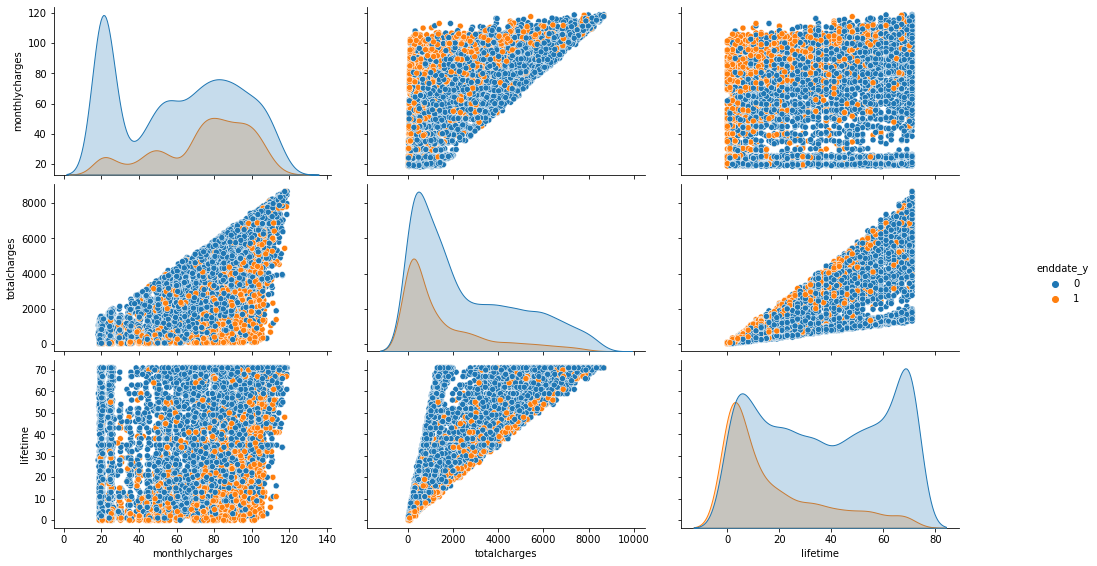

In [31]:
numerical=['monthlycharges', 'totalcharges','lifetime']
categorical = list(set(df_cleaned.columns) - set(numerical))
categorical.remove('enddate_y')
sns.pairplot(df_cleaned, vars=numerical, hue='enddate_y').fig.set_size_inches(16,8)
plt.show()

In [32]:
df_cleaned.groupby(['enddate_y'])['monthlycharges'].describe()

,count,mean,std,min,25%,50%,75%,max
enddate_y,,,,,,,,
0,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
1,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


ежемесячные платежи в группе ушедших клиентов выше, чем у лояльных. Это наблюдается во всем квартильном диапазоне. Сравним этот признак между группами по критерию Стьюдента

H0-нулевая гипотеза о равенстве средних, H1 - альтернативная гипотеза о различии средних

In [33]:
alpha = 0.05
m0=df_cleaned.loc[df_cleaned['enddate_y']==0,'monthlycharges']
m1=df_cleaned.loc[df_cleaned['enddate_y']==1,'monthlycharges']
t0=df_cleaned.loc[df_cleaned['enddate_y']==0,'totalcharges']
t1=df_cleaned.loc[df_cleaned['enddate_y']==1,'totalcharges']
results = st.ttest_ind(m0,m1)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.706645606888261e-60
Отвергаем нулевую гипотезу


In [34]:
results = st.ttest_ind(t0,t1)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.057691578421339e-63
Отвергаем нулевую гипотезу


В обоих случаях при проверке гипотезе о равенстве средних в группах ушедших клиентов и лояльных нулевые гипотезы были отвергнуты при уровне значимости - 0.05. Отсюда следует, что наблюдаются статистически значимые различия между группами по показателям ежемесячных расходов и общих расходов.

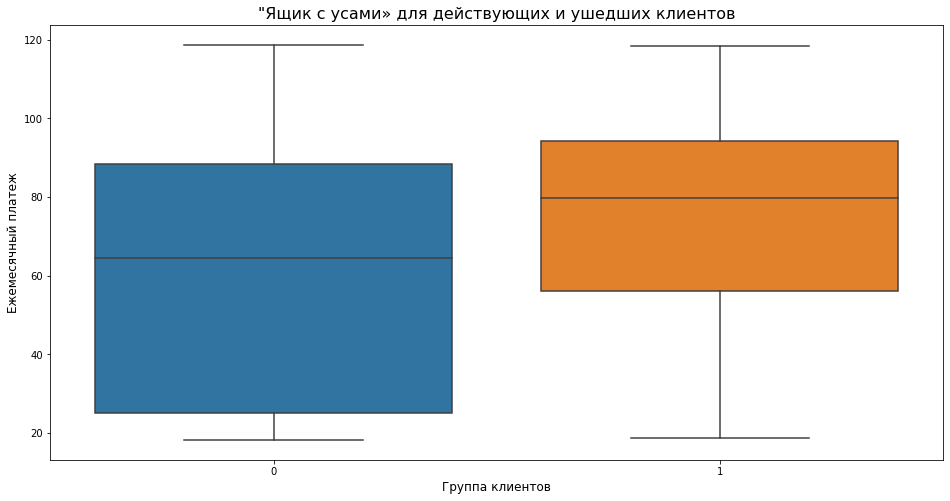

In [35]:
sns.boxplot(x = 'enddate_y', y = 'monthlycharges', data = df)
plt.title('"Ящик с усами» для действующих и ушедших клиентов', fontsize = 16)
plt.xlabel('Группа клиентов', fontsize = 12)
plt.ylabel('Ежемесячный платеж', fontsize = 12)
plt.show()

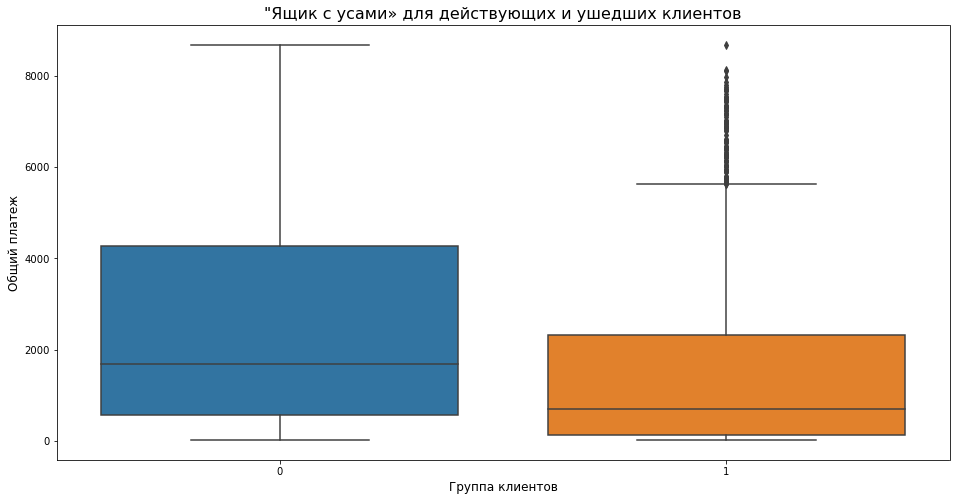

In [36]:
sns.boxplot(x = 'enddate_y', y = 'totalcharges', data = df)
plt.title('"Ящик с усами» для действующих и ушедших клиентов', fontsize = 16)
plt.xlabel('Группа клиентов', fontsize = 12)
plt.ylabel('Общий платеж', fontsize = 12)
plt.show()

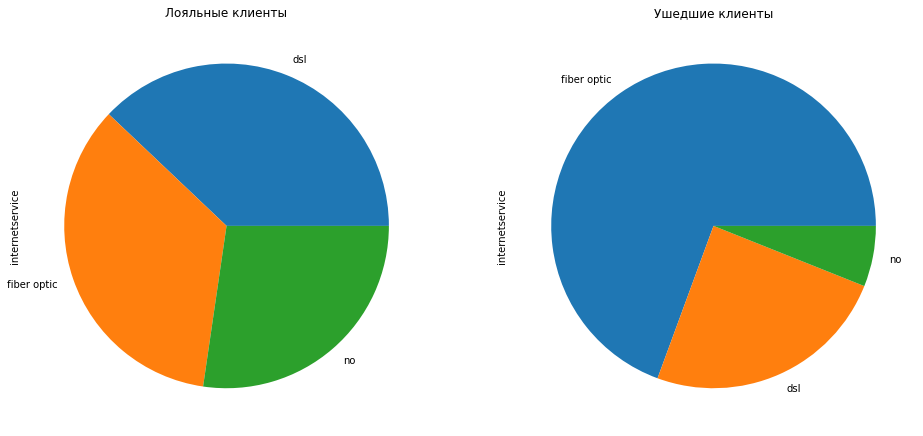

In [37]:
plt.figure(figsize=(16,12))
plt.subplot(1, 2, 1)
df_cleaned[df_cleaned['enddate_y'] == 0]['internetservice'].value_counts().plot(kind='pie', title='Лояльные клиенты')
plt.subplot(1, 2, 2)
df_cleaned[df_cleaned['enddate_y'] == 1]['internetservice'].value_counts().plot(kind='pie', title='Ушедшие клиенты')
plt.show()

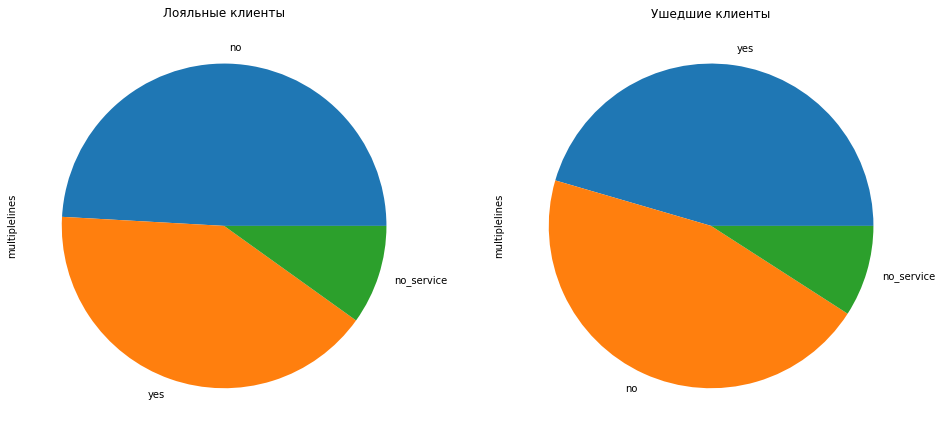

In [38]:
plt.figure(figsize=(16,12))
plt.subplot(1, 2, 1)
df_cleaned[df_cleaned['enddate_y'] == 0]['multiplelines'].value_counts().plot(kind='pie', title='Лояльные клиенты')
plt.subplot(1, 2, 2)
df_cleaned[df_cleaned['enddate_y'] == 1]['multiplelines'].value_counts().plot(kind='pie', title='Ушедшие клиенты')
plt.show()

Большая чать ушедших клиентов приходится на клиентов с опто-волоконным соеденением. Каких-либо закономерностей в данных по телефонии не обнаружено

1 Суммарные расходы в обоих группах распределены одинаково
2 Месячные расходы клиентов, пользующихся услугами как правило ниже расходов ушедших клиентов
3.Клиенты в большинстве случаев уходят в течении года после подключения услуг.



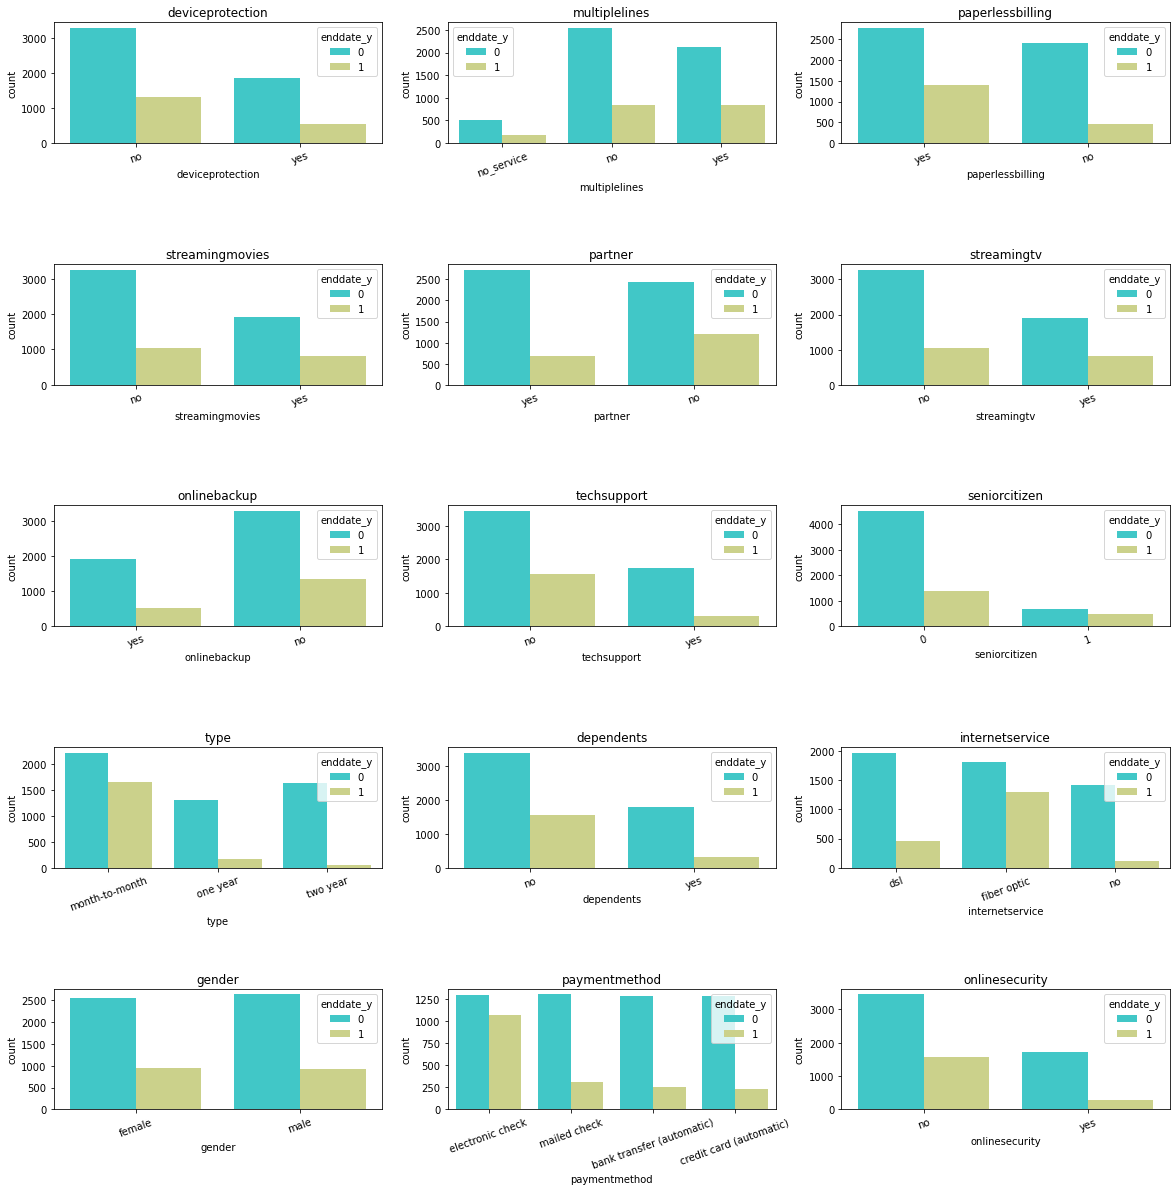

In [39]:
fig, ax = plt.subplots(5,3,figsize=(20,20))

for i, col in enumerate(categorical):
    plt.subplot(5, 3, i + 1, title=col)
    sns.countplot(data=df_cleaned, x=col, hue='enddate_y',palette='rainbow')
    plt.xticks(rotation=20)
plt.subplots_adjust(hspace=1)
plt.show()

Наибольший отток наблюдается среди клиентов, оплачивающих счета электронным чеком или без возможности безналичного расчета, с помесячной оплатой, отсутствием техподдержки, использующих оптоволоконную сеть. Чаще всего уходят люди не пенсионного возраста и без иждевенцев.

Рассчитаем значения хи-квадрат

interval columns not set, guessing: ['seniorcitizen', 'monthlycharges', 'totalcharges', 'enddate_y', 'lifetime']


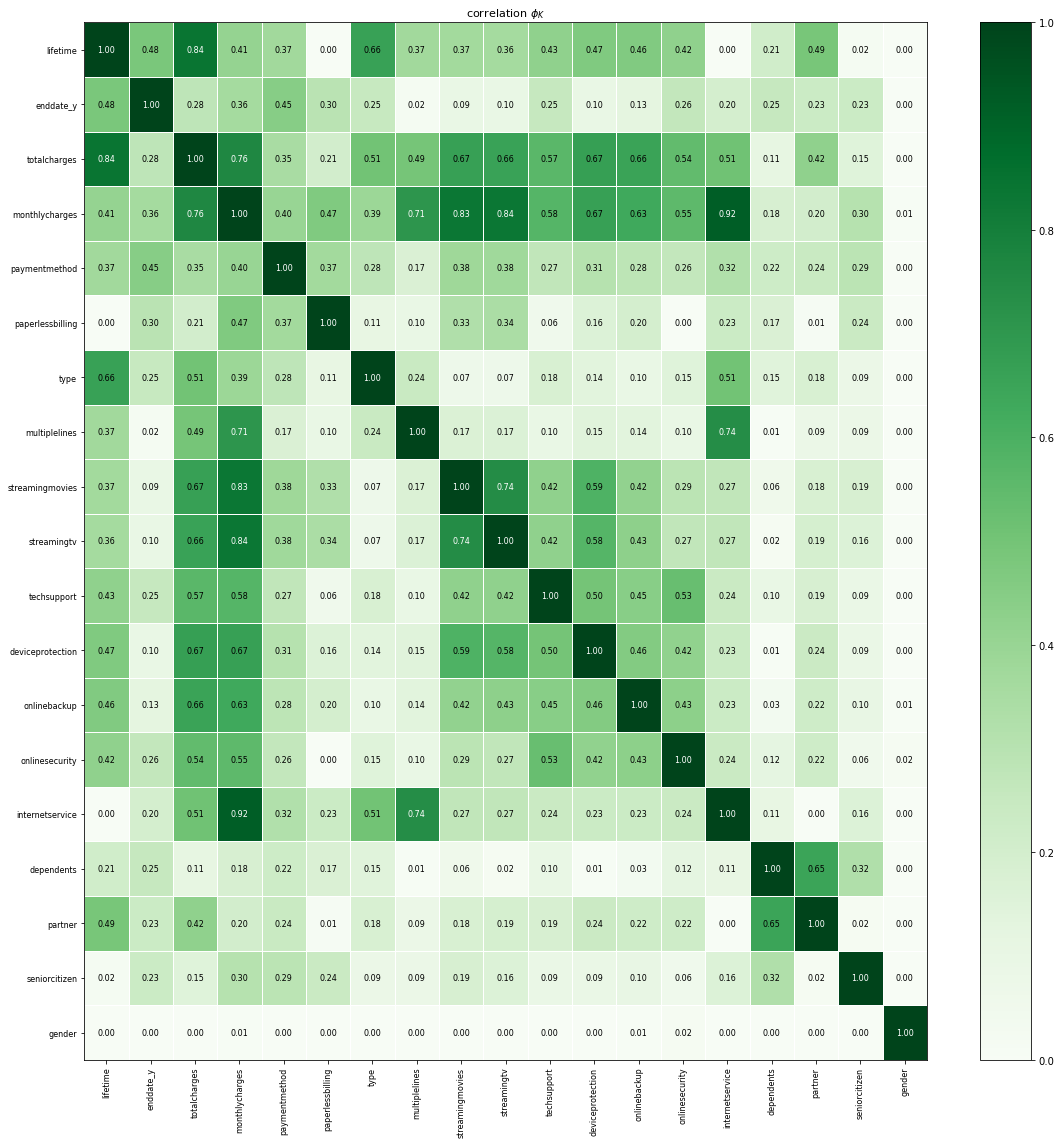

In [40]:
phik_overview = df_cleaned.phik_matrix(interval_cols=None)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8,
                        figsize=(16, 16))
plt.tight_layout()

interval columns not set, guessing: ['seniorcitizen', 'monthlycharges', 'totalcharges', 'enddate_y', 'lifetime']


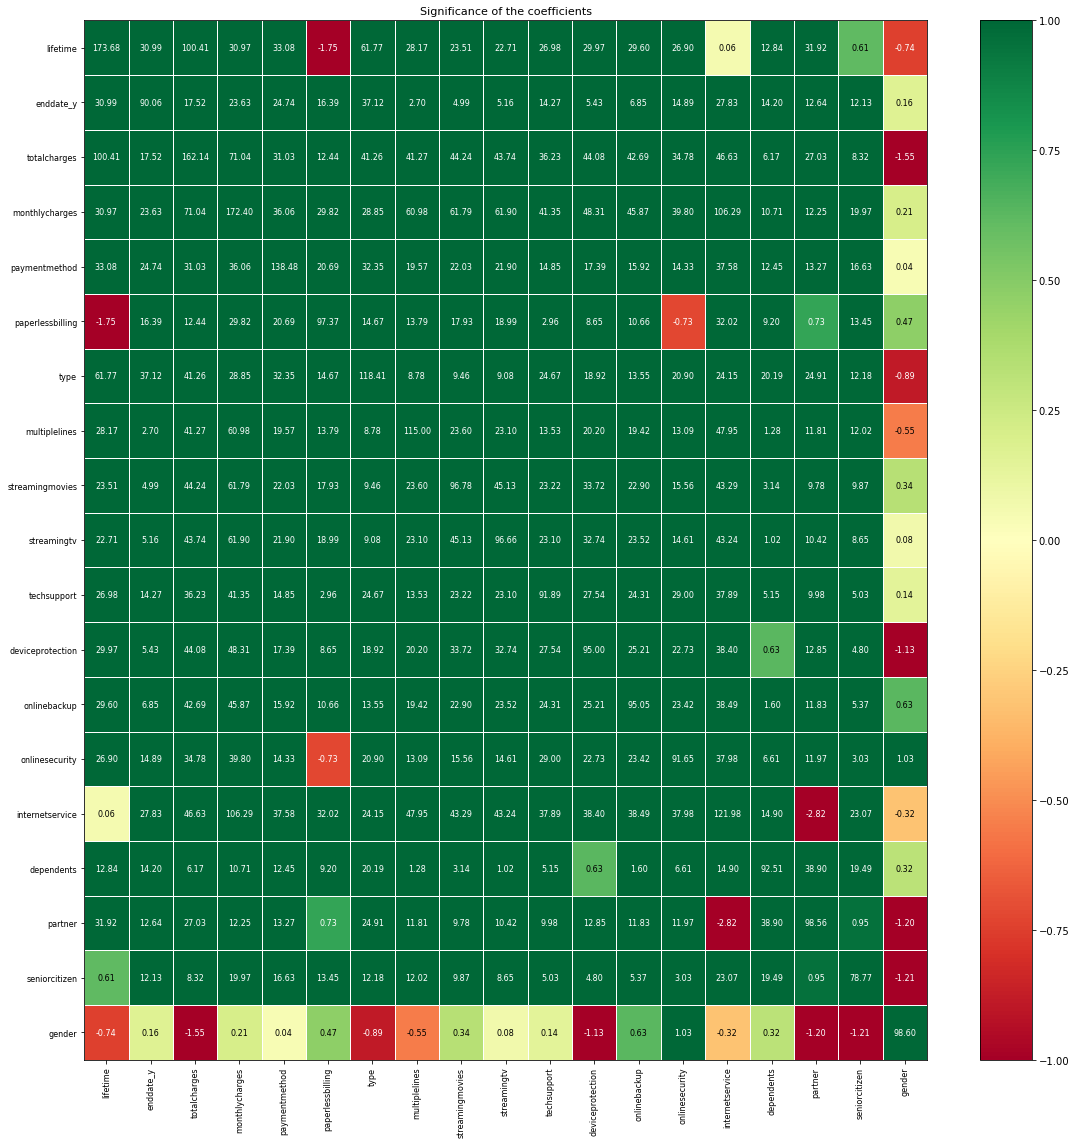

In [41]:
significance_overview = df_cleaned.significance_matrix(interval_cols=None)
plot_correlation_matrix(significance_overview.fillna(0).values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        title="Significance of the coefficients",
                        usetex=False, fontsize_factor=0.8, figsize=(16, 16))
plt.tight_layout()

Признак  montlycharges избыточен (т.к. рассчитывается по столбцам lifetime и totalcharges ) и может привести к мультиколлинеарности. Поэтому удалим его

In [42]:
df_cleaned = df_cleaned.drop(['monthlycharges'],axis=1)
numerical.remove('monthlycharges')

Пропишем функции расчета метрик, значимости признаков, а так же scorer для auc-roc

In [78]:
def score(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    pred_proba_test = model.predict_proba(X_test)[:, 1]
    predicted_test = model.predict(X_test)
    print('Accuracy: ', round(accuracy_score(y_test,predicted_test), 3))
    print('Precision: ', round(precision_score(y_test,predicted_test), 3))
    print('Recall: ', round(recall_score(y_test,predicted_test), 3))
    print('AUC-ROC: ', round(roc_auc_score(y_test,pred_proba_test), 3))
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    plot_confusion_matrix(model, X_test, y_test,cmap='PuBuGn')


In [44]:
def importance(model,features):
    imp = pd.Series(model.feature_importances_,index=features.columns).sort_values(ascending=False)
    ax = sns.barplot(x=imp,y=imp.index)
    ax.set(xlabel = 'Важность признаков',ylabel ='Признаки')
    return imp

In [45]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

Разобьем выборку на валидационную и тестовую

In [46]:
X = df_cleaned.drop(['enddate_y'],axis=1)
y = df_cleaned['enddate_y']
ros = RandomOverSampler()

X_ros, y_ros = ros.fit_resample(X, y)
print(Counter(y_ros))


Counter({0: 5174, 1: 5174})


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X_ros, y_ros, test_size=0.2, stratify=y_ros, random_state=random_seed)

Нормализуем количественные данные, а также закодируем категоризированные данные для моделей( кроме catboost)

In [48]:
X_test.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines', 'type',
       'paperlessbilling', 'paymentmethod', 'totalcharges', 'lifetime'],
      dtype='object')

In [49]:
X_train.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines', 'type',
       'paperlessbilling', 'paymentmethod', 'totalcharges', 'lifetime'],
      dtype='object')

In [50]:
cat_pipe = Pipeline([
       ('encoder', OneHotEncoder(drop='first'))
])

num_pipe = Pipeline([
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])
preprocessor.fit(X_train)

cat_columns = preprocessor.named_transformers_['cat']['encoder'].get_feature_names(categorical)
columns = np.append(cat_columns, numerical)
X_train=pd.DataFrame(preprocessor.transform(X_train), columns=columns)
preprocessor.fit(X_test)
X_test=pd.DataFrame(preprocessor.transform(X_test), columns=columns)

In [51]:
X_train.head()

,deviceprotection_yes,multiplelines_no_service,multiplelines_yes,paperlessbilling_yes,streamingmovies_yes,partner_yes,streamingtv_yes,onlinebackup_yes,techsupport_yes,seniorcitizen_1,...,dependents_yes,internetservice_fiber optic,internetservice_no,gender_male,paymentmethod_credit card (automatic),paymentmethod_electronic check,paymentmethod_mailed check,onlinesecurity_yes,totalcharges,lifetime
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.010247,0.084507
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.589176,0.788732
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.021492,0.028169
3,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.118544,0.154930
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.659249,0.859155


In [52]:
X_train.columns[:-2]

Index(['deviceprotection_yes', 'multiplelines_no_service', 'multiplelines_yes',
       'paperlessbilling_yes', 'streamingmovies_yes', 'partner_yes',
       'streamingtv_yes', 'onlinebackup_yes', 'techsupport_yes',
       'seniorcitizen_1', 'type_one year', 'type_two year', 'dependents_yes',
       'internetservice_fiber optic', 'internetservice_no', 'gender_male',
       'paymentmethod_credit card (automatic)',
       'paymentmethod_electronic check', 'paymentmethod_mailed check',
       'onlinesecurity_yes'],
      dtype='object')

In [53]:
categorical=X_train.columns[:-2]
vif_data = pd.DataFrame()
vif_data["feature"] = categorical
vif_data["VIF"] = [variance_inflation_factor(X_train[categorical].values, i)
                   for i in range(len(X_train[categorical].columns))]

In [54]:
print(vif_data)

                                  feature       VIF
0                    deviceprotection_yes  2.016207
1                multiplelines_no_service  1.379670
2                       multiplelines_yes  2.330538
3                    paperlessbilling_yes  3.070868
4                     streamingmovies_yes  2.557819
5                             partner_yes  2.469979
6                         streamingtv_yes  2.574224
7                        onlinebackup_yes  1.828747
8                         techsupport_yes  1.815055
9                         seniorcitizen_1  1.424283
10                          type_one year  1.601108
11                          type_two year  2.106120
12                         dependents_yes  1.813412
13            internetservice_fiber optic  3.681055
14                     internetservice_no  2.157037
15                            gender_male  1.900627
16  paymentmethod_credit card (automatic)  1.671156
17         paymentmethod_electronic check  2.630127
18          

<AxesSubplot:>

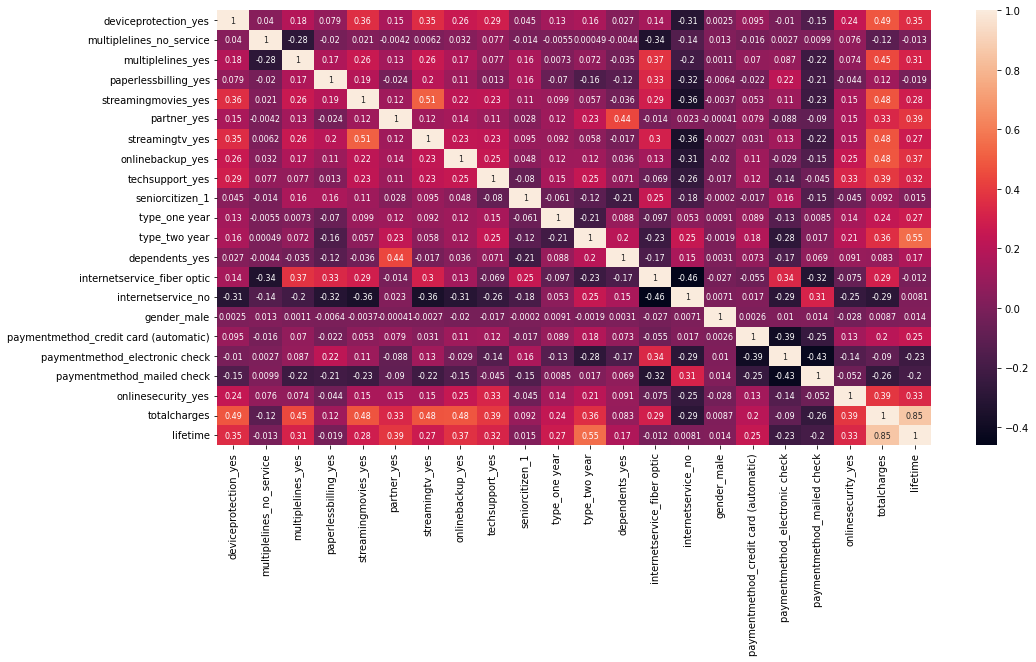

In [55]:
sns.heatmap(X_train.corr(),annot=True,annot_kws={"fontsize":8})

Фактор инфляции дисперсии во всех признаках меньше 5, мультиколлинеарность низкая.  Данные признаки можно использовать для обучения модели

# 2. Выбор модели #

Проверим данные на дисбаланс классов

In [56]:
class_count_0, class_count_1 = y_test.value_counts()

print('class 0:', class_count_0)
print('class 1:', class_count_1)
weight=class_count_1/class_count_0

class 0: 1035
class 1: 1035


In [57]:
K = 8
kf = KFold(n_splits = K, random_state = random_seed, shuffle = True)

***Dummy***

Accuracy:  0.5
Presicion:  0.0
Recall:  0.0
AUC-ROC:  0.5


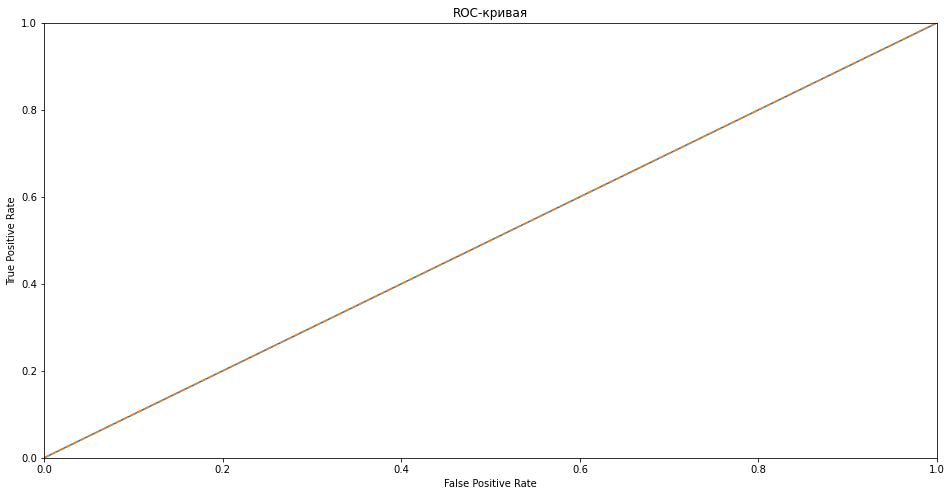

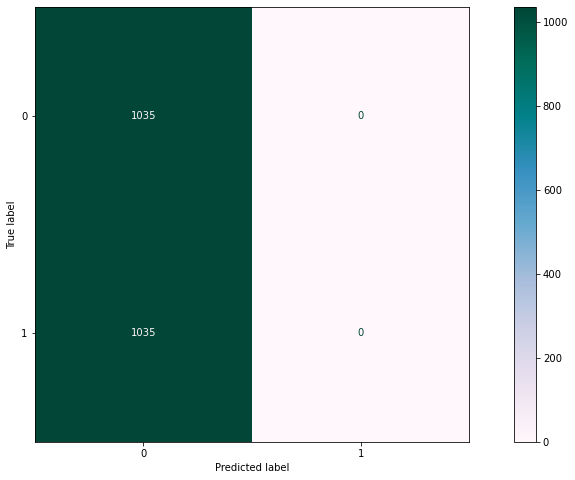

In [58]:
model_dummy = DummyClassifier()
score(model_dummy,X_train, y_train, X_test,y_test)

***LogisticRegression***

Accuracy:  0.766
Presicion:  0.74
Recall:  0.821
AUC-ROC:  0.846


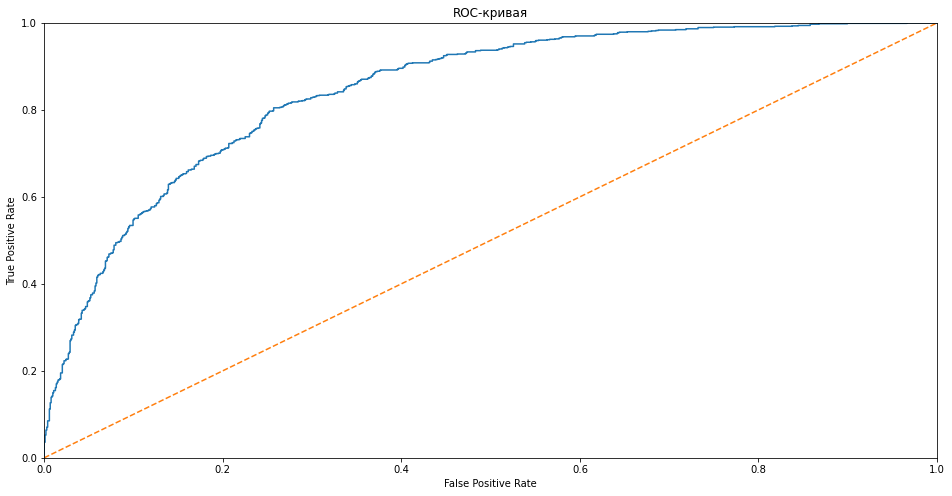

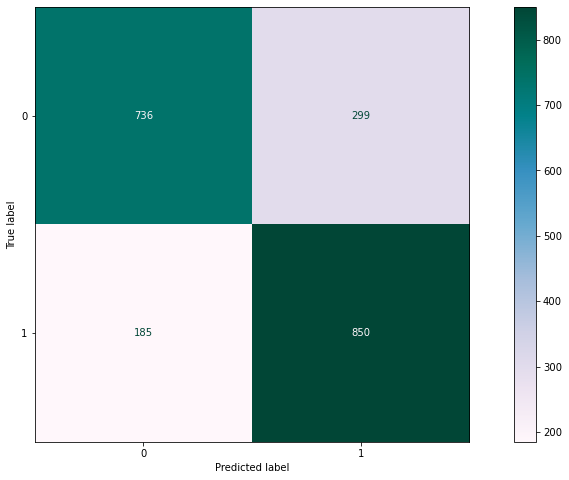

In [59]:
model_logistic = LogisticRegression(random_state=random_seed)
score(model_logistic,X_train,y_train,X_test,y_test)

***Random Forest Classifier***

In [60]:
%%time


param_dist ={
    'max_features':[int(x) for x in np.linspace (start = 3, stop = 11, num =2)],
    'min_samples_leaf' : np.arange(3, 11, 2),
    'min_samples_split':[2,5,10,15,100],
    'n_estimators': [100,300,500,800]   }
clf = GridSearchCV(RandomForestClassifier(random_state=random_seed),
                   param_dist,
                   scoring=roc_auc_scorer,
                   verbose=1,
                   cv=kf
                   )
clf.fit(X_train,y_train)
print('Best params:',clf.best_params_,'Best roc_auc:',clf.best_score_)

Fitting 8 folds for each of 160 candidates, totalling 1280 fits
Best params: {'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 800} Best roc_auc: 0.9314092075499841
Wall time: 48min 30s


In [61]:
model_forest=RandomForestClassifier(random_state=random_seed,**clf.best_params_)
best_params_forest=clf.best_params_

Accuracy:  0.857
Presicion:  0.822
Recall:  0.912
AUC-ROC:  0.938


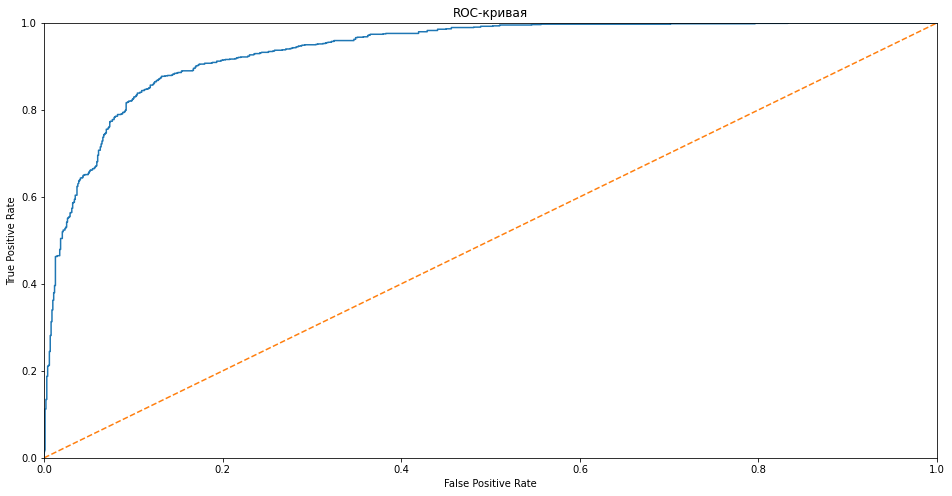

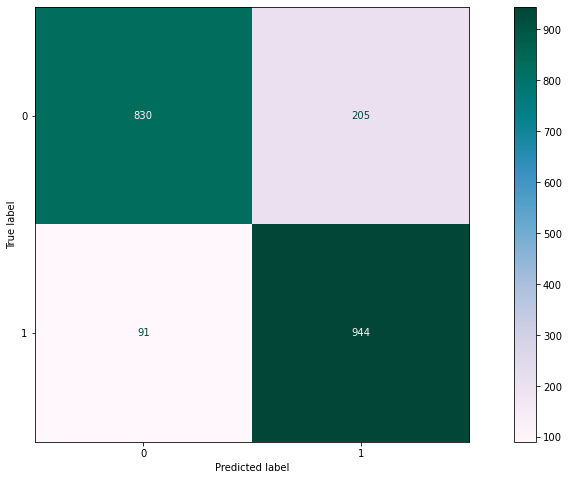

In [62]:
score(model_forest,X_train,y_train,X_test,y_test)

lifetime                                 0.215758
totalcharges                             0.206161
type_two year                            0.128094
internetservice_fiber optic              0.090922
type_one year                            0.042869
internetservice_no                       0.034532
paymentmethod_electronic check           0.032895
gender_male                              0.023609
paperlessbilling_yes                     0.022177
streamingmovies_yes                      0.019320
onlinebackup_yes                         0.019035
partner_yes                              0.018794
onlinesecurity_yes                       0.018653
techsupport_yes                          0.017905
streamingtv_yes                          0.017782
seniorcitizen_1                          0.017143
dependents_yes                           0.015255
multiplelines_yes                        0.015093
deviceprotection_yes                     0.014346
paymentmethod_mailed check               0.010758


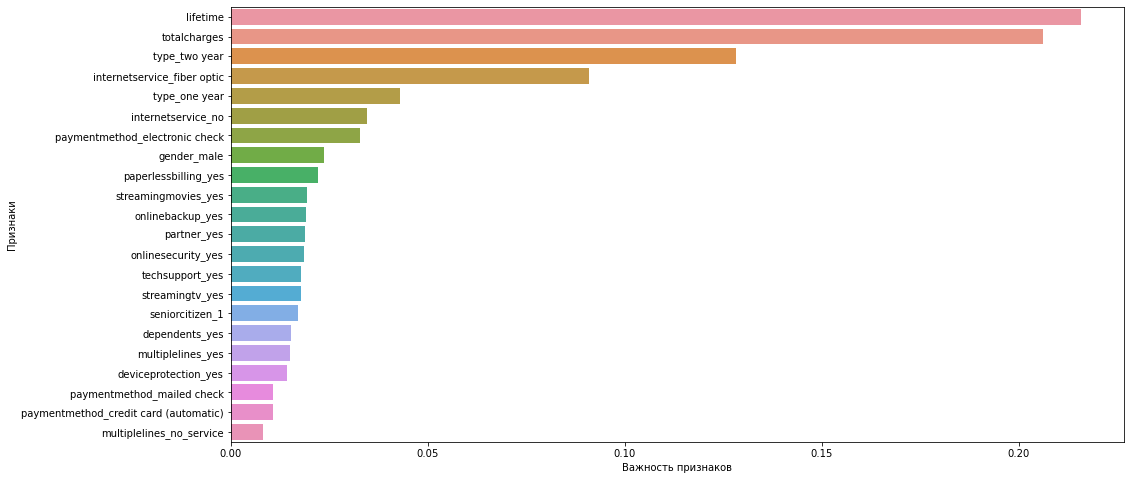

In [63]:
importance(model_forest,X_test)

***XGBClassifier***

In [64]:
%%time
param_dist={'max_depth': range(1, 10),
            'learning_rate': np.arange(0.01, 0.1, 0.3),
            'eta':[0.01, 0.1,0.2,0.3],
            'n_estimators': [100, 300,500],
            'eval_metric':['auc']
            }

clf = GridSearchCV(XGBClassifier(random_state=random_seed),
                   param_dist,
                   scoring='roc_auc',
                   verbose=0,
                   cv=kf
                   )
clf.fit(X_train,y_train)
print('Best params:',clf.best_params_,'Best roc_auc:',clf.best_score_)

Best params: {'eta': 0.01, 'eval_metric': 'auc', 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500} Best roc_auc: 0.90766694138048
Wall time: 22min 39s


In [65]:
model_xgb=XGBClassifier(random_state=random_seed,**clf.best_params_)
best_params_xgb=clf.best_params_

Accuracy:  0.828
Presicion:  0.791
Recall:  0.89
AUC-ROC:  0.905


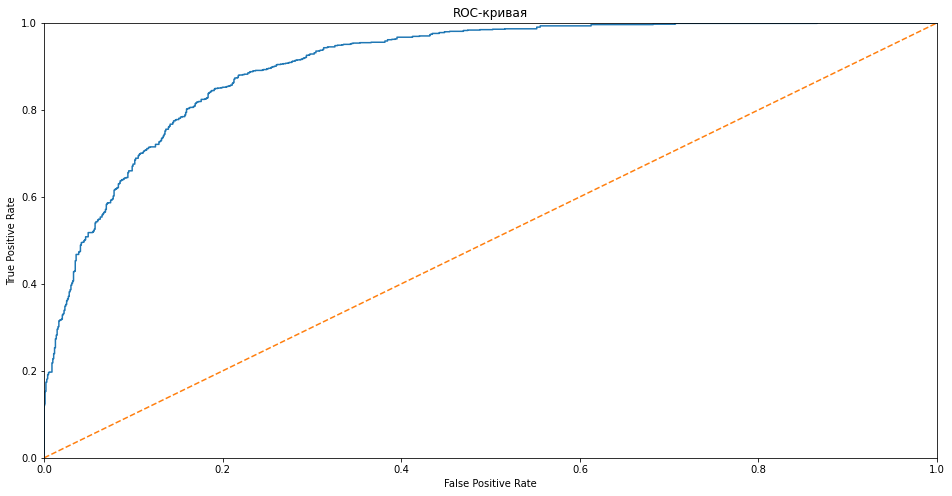

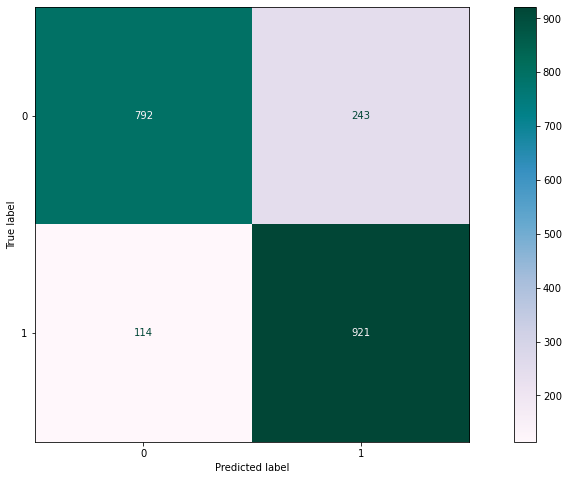

In [66]:
score(model_xgb,X_train,y_train,X_test,y_test)

type_two year                            0.462248
type_one year                            0.262135
internetservice_fiber optic              0.066253
internetservice_no                       0.036701
streamingmovies_yes                      0.032904
lifetime                                 0.016147
multiplelines_no_service                 0.012850
techsupport_yes                          0.009740
paymentmethod_electronic check           0.009058
streamingtv_yes                          0.008860
totalcharges                             0.008720
onlinesecurity_yes                       0.008417
onlinebackup_yes                         0.008095
paperlessbilling_yes                     0.007936
seniorcitizen_1                          0.007520
multiplelines_yes                        0.007241
paymentmethod_mailed check               0.007119
gender_male                              0.006678
deviceprotection_yes                     0.005829
dependents_yes                           0.005375


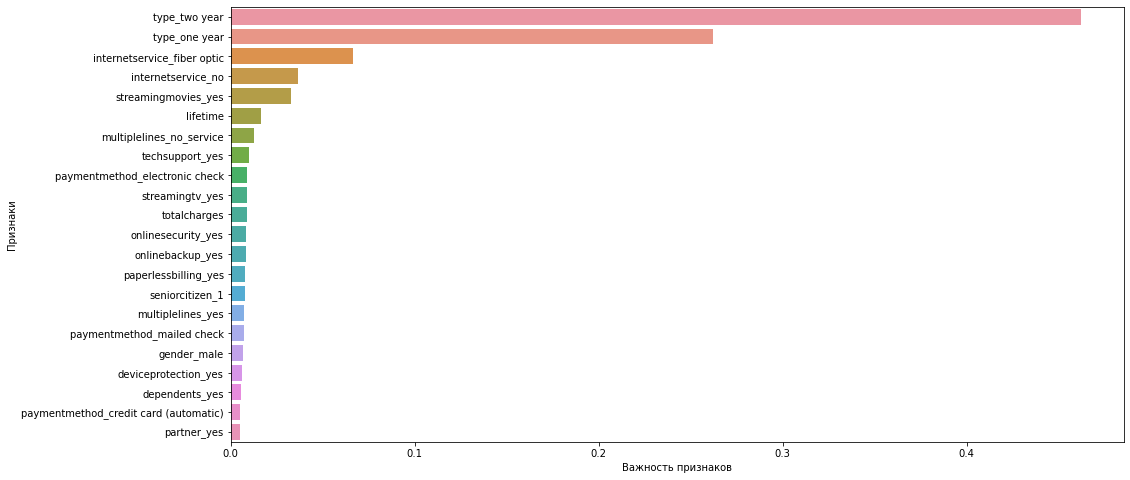

In [67]:
importance(model_xgb,X_test)

***LGBM Classifier***

In [68]:
param_dist = {'n_estimators': [100, 300],
              'learning_rate': [0.01, 0.1, 0.2, 0.3,],
              'num_iterations':[300,500,1000],
              'num_leaves':[31,51],
              'objective':['binary'],
}

clf = GridSearchCV(LGBMClassifier(n_jobs=-1, random_state=random_seed),
                   param_dist,
                   scoring='roc_auc',
                   verbose=0,
                   cv=kf
                   )
clf.fit(X_train,y_train)
print('Best params:',clf.best_params_,'Best roc_auc:',clf.best_score_)

Best params: {'learning_rate': 0.2, 'n_estimators': 100, 'num_iterations': 1000, 'num_leaves': 51, 'objective': 'binary'} Best roc_auc: 0.9540308899504975


In [69]:
model_lgbm=LGBMClassifier(random_state=random_seed,**clf.best_params_)
best_params_lgbm=clf.best_params_

Accuracy:  0.89
Presicion:  0.854
Recall:  0.941
AUC-ROC:  0.959


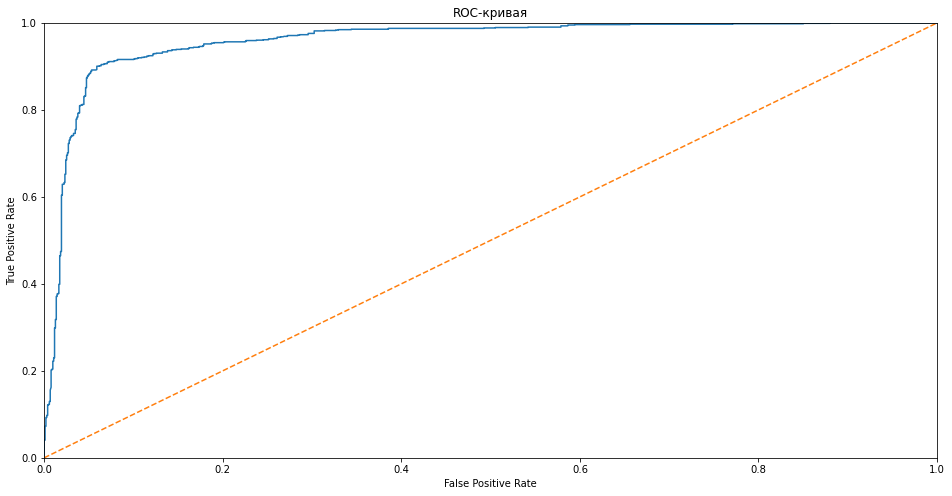

Wall time: 2.18 s


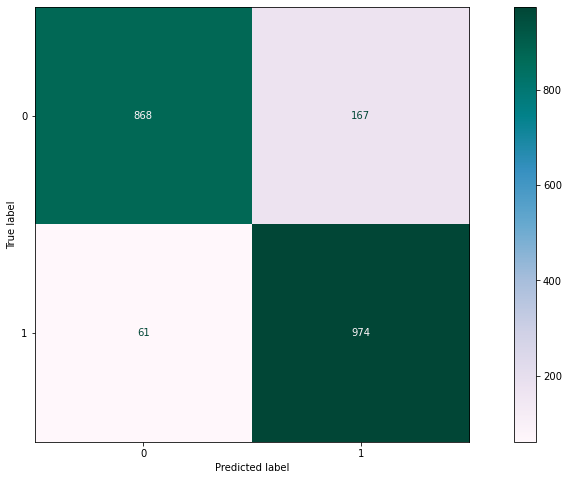

In [77]:
%%time
score(model_lgbm,X_train,y_train,X_test,y_test)

totalcharges                             20532
lifetime                                 10062
gender_male                               2295
paymentmethod_electronic check            1778
partner_yes                               1534
paperlessbilling_yes                      1432
onlinebackup_yes                          1364
deviceprotection_yes                      1145
multiplelines_yes                         1116
streamingtv_yes                           1021
seniorcitizen_1                           1018
streamingmovies_yes                        977
dependents_yes                             909
onlinesecurity_yes                         847
internetservice_fiber optic                735
paymentmethod_mailed check                 715
techsupport_yes                            707
paymentmethod_credit card (automatic)      644
type_one year                              548
multiplelines_no_service                   264
internetservice_no                         189
type_two year

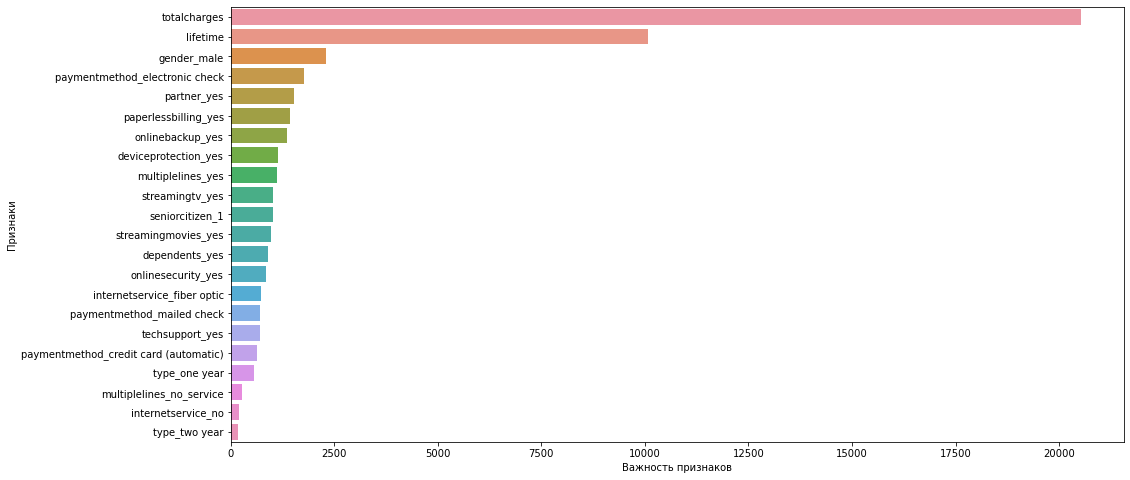

In [72]:
importance(model_lgbm,X_test)

Все наши модели слабоватые, поэтому было принято использовать ансамблевый метод с голосованием по нашим моделям

# 4. Отчет #

**Какие пункты плана были выполнены?**
- Проведена предобработка данных (заполнены пропуски, удалены неинформативные столбцы, убран дисбаланс классов)
- Проведен исследовательский анализ данных (построены графики распределения, рассчитаны коэффициенты хи-квадрат для категориальных данных, исследованы данные на мультиколлинеарность, проведена проверка гипотезы о равенстве средних для групп лояльных и ушедших клиентов, рассчитаны коэффициенты инфляции дисперсии)
- Подобраны и обучены модели, рассчитаны коэффициенты важности признаков для каждой модели.

**Какие трудности возникли и как вы их преодолели?**
-Трудность возникла с подбором алгоритма работы с дисбалансом. Изначально пробовал применить SMOTE, из-за чего метрики на всех моделях были ужасны. В итоге решил отказаться от этого алгоритма.
**Какие ключевые шаги в решении задачи выделили?**
Ключевые шаги-EDA,работа с дисбалансом и проверка признаков на мультиколлинеарность
**Какая ваша итоговая модель и какое у нее качество?**
LGBM Classifier
Best params: {'learning_rate': 0.2, 'n_estimators': 100, 'num_iterations': 1000, 'num_leaves': 51, 'objective': 'binary'}
Метрики на тестовой выборке -
Accuracy:  0.89
Precision:  0.854
Recall:  0.941
AUC-ROC:  0.959

**Общие выводы**

1. Наибольший отток наблюдается среди клиентов, оплачивающих счета электронным чеком или без возможности безналичного расчета, с помесячной оплатой, отсутствием техподдержки, использующих оптоволоконную сеть. Чаще всего уходят люди не пенсионного возраста и без иждевенцев.Месячные расходы клиентов, пользующихся услугами как правило ниже расходов ушедших клиентов.Клиенты в большинстве случаев уходят в течении года после подключения услуг.
2.Клиенты в большинстве случаев уходят в течении года после подключения услуг.
3. Анализ значимости признаков модели частично подтвердили предположения, практически во всех моделях фигурируют признаки размера оплаты услуг, время пользованием услуг, способ оплаты и тарифные планы, а также способ подключение(оптоволоконные сети).
4. Лучшая модель предсказания - LGBM Classifier. Метрики на тестовой выборке -
Accuracy:  0.89
Presicion:  0.854
Recall:  0.941
AUC-ROC:  0.959
